# Change Point Analysis and Statistical Modeling for Assessing Event-Driven Impacts on Brent Oil Prices

# Overview
This study investigates how significant political, economic, and environmental events affect Brent oil prices. Using change point analysis and Bayesian statistical modeling, we aim to pinpoint key moments of change in historical price data and associate these changes with major events like policy shifts, geopolitical tensions, sanctions, and OPEC decisions. By understanding these links, stakeholders can gain insights into the dynamics driving oil market volatility.

# Business Need
The oil market's high volatility poses challenges for investors, policymakers, and energy companies. To effectively manage risk and strategize in response to rapid price shifts, these stakeholders require insights into the factors behind oil price changes. Birhan Energies, a consultancy specializing in energy market intelligence, aims to provide this actionable intelligence. Understanding how specific events impact Brent oil prices will help clients make informed investment decisions, develop resilient policies, and optimize operational strategies.

# Objective

1. Identify key events that have impacted Brent oil prices over the past decade.
2. Quantify the effect of each event on oil price changes.
3. Develop a comprehensive data-driven analysis framework for detecting change points in oil prices and linking them with causal events.
4. Generate insights to inform investment strategies, policy decisions, and operational planning for stakeholders in the energy sector.

## 1. Data Collection

### Import Necesary Library

In [33]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

### Load Dataset

In [34]:
#df = pd. read_csv('/kaggle/input/doil-ataset/BrentOilPrices.csv')
df = pd. read_csv('../data/BrentOilPrices.csv')
df

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63
...,...,...
9006,"Nov 08, 2022",96.85
9007,"Nov 09, 2022",93.05
9008,"Nov 10, 2022",94.25
9009,"Nov 11, 2022",96.37


## 2. Data Preprocessing

In [35]:
df.shape

(9011, 2)

In [36]:
df.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [37]:
# Display the data types of each column
print(df.dtypes)

Date      object
Price    float64
dtype: object


## Data Cleaning 

In [38]:
# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing Values:\n{missing_values}")

Missing Values:
Date     0
Price    0
dtype: int64


In [39]:
df.duplicated().sum()

0

### Data time Conversion

In [40]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Set 'Date' as the index
df.set_index('Date', inplace=True)

C:\Users\getac\AppData\Local\Temp\ipykernel_14468\2977810802.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [41]:
# Ensure 'Price' is a float
df['Price'] = df['Price'].astype(float)

In [42]:
df.dtypes

Price    float64
dtype: object

### Outlier Detection and Treatment

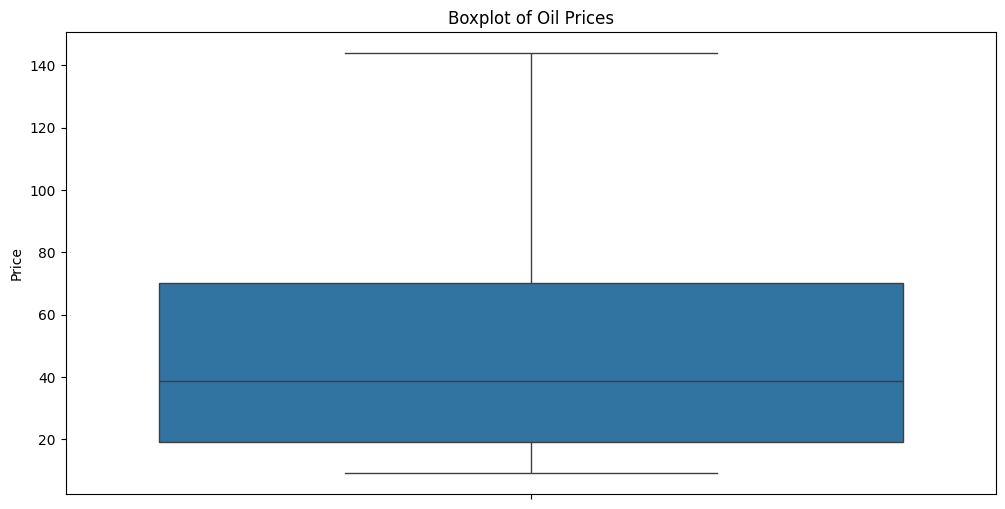

In [43]:
# Visualize the data to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(y=df['Price'])
plt.title('Boxplot of Oil Prices')
plt.show()


In [44]:
# Remove outliers using IQR method
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR)))]

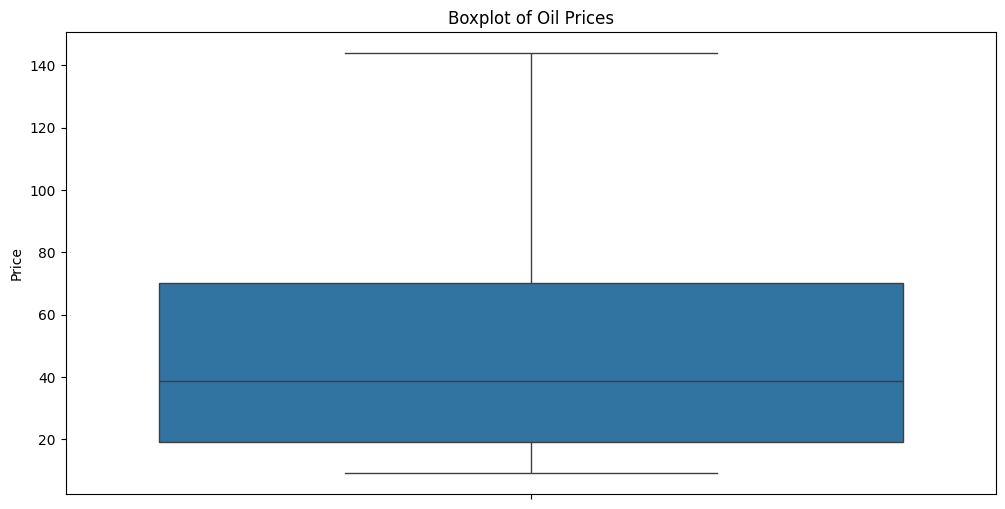

In [45]:
# Visualize the data to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(y=df['Price'])
plt.title('Boxplot of Oil Prices')
plt.show()

### Feature Engineering

In [46]:
# Example of creating new features from the Date index
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day


In [47]:
df.head()

,Price,Year,Month,Day
Date,,,,
1987-05-20,18.63,1987,5,20
1987-05-21,18.45,1987,5,21
1987-05-22,18.55,1987,5,22
1987-05-25,18.60,1987,5,25
1987-05-26,18.63,1987,5,26


## 3. Exploratory Data Analysis (EDA)

### Trends of oil price over a time

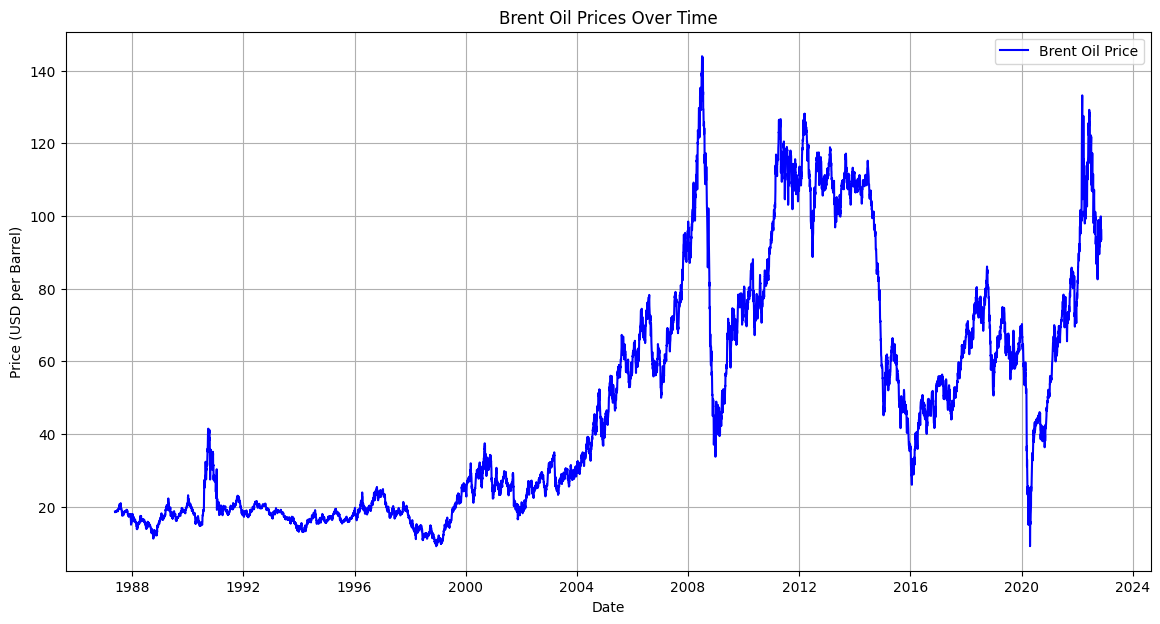

In [48]:
# Plotting the time series of Brent Oil Prices
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price', color='blue')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD per Barrel)')
plt.legend()
plt.grid()
plt.show()

C:\Users\getac\AppData\Local\Temp\ipykernel_14468\108302096.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_trend = df['Price'].resample('M').mean() # Monthly average
C:\Users\getac\AppData\Local\Temp\ipykernel_14468\108302096.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_trend = df['Price'].resample('Y').mean()  # Yearly average


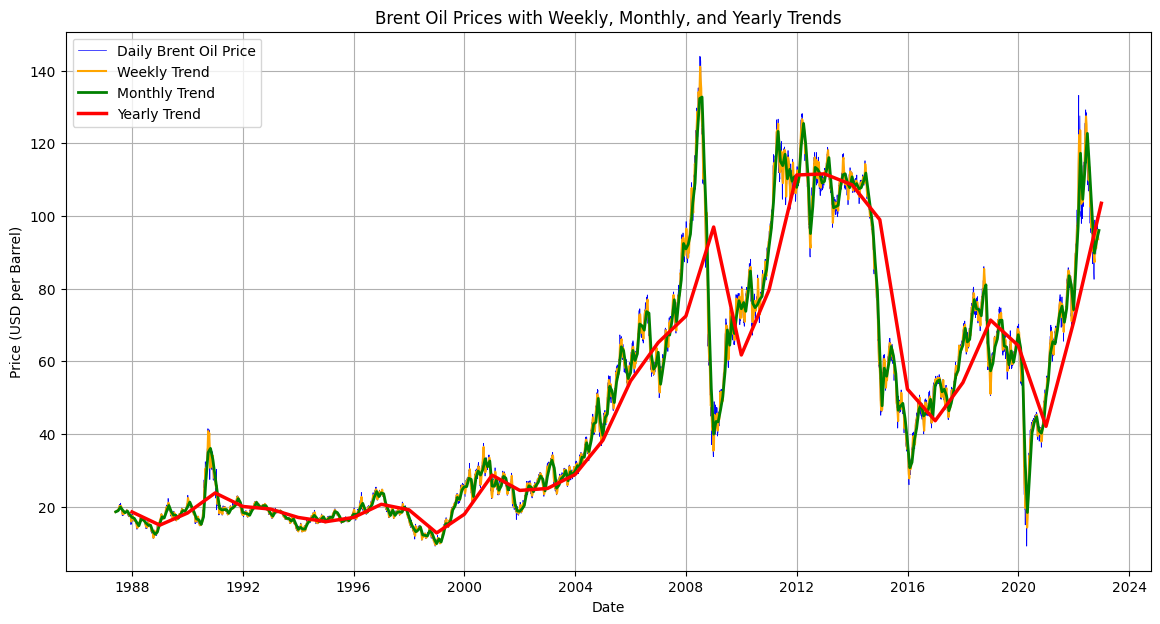

In [49]:
# Calculate weekly, monthly, and yearly trends by resampling
weekly_trend = df['Price'].resample('W').mean()  # Weekly average
monthly_trend = df['Price'].resample('M').mean() # Monthly average
yearly_trend = df['Price'].resample('Y').mean()  # Yearly average

# Plotting the original Brent Oil Prices and the trends
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Daily Brent Oil Price', color='blue', linewidth=0.5)
plt.plot(weekly_trend.index, weekly_trend, label='Weekly Trend', color='orange', linewidth=1.5)
plt.plot(monthly_trend.index, monthly_trend, label='Monthly Trend', color='green', linewidth=2)
plt.plot(yearly_trend.index, yearly_trend, label='Yearly Trend', color='red', linewidth=2.5)

# Add labels and title
plt.title('Brent Oil Prices with Weekly, Monthly, and Yearly Trends')
plt.xlabel('Date')
plt.ylabel('Price (USD per Barrel)')
plt.legend()  # Show the legend
plt.grid()

### Checking for Stationarity

C:\Users\getac\AppData\Local\Temp\ipykernel_14468\3073976021.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Simple Moving Averages')


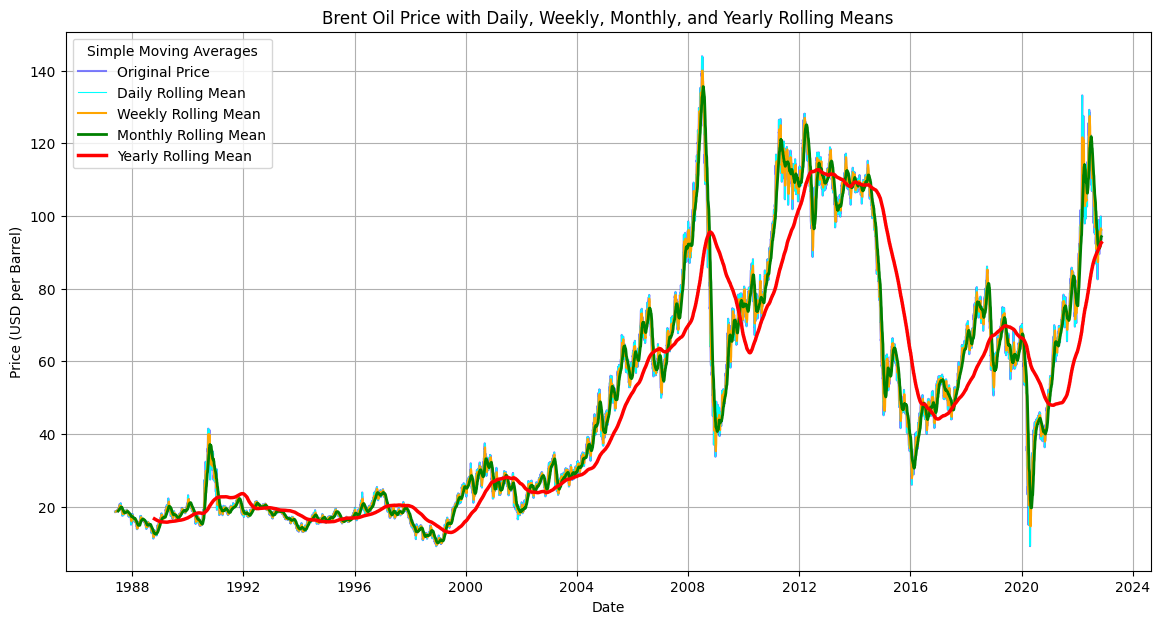

In [50]:
# Calculate rolling means with different windows (daily, weekly, monthly, yearly)
daily_rolling_mean = df['Price'].rolling(window=1).mean()     # Daily rolling mean
weekly_rolling_mean = df['Price'].rolling(window=7).mean()    # Weekly rolling mean
monthly_rolling_mean = df['Price'].rolling(window=30).mean()  # Approximate monthly rolling mean
yearly_rolling_mean = df['Price'].rolling(window=365).mean()  # Approximate yearly rolling mean

# Plot rolling means for different windows
plt.figure(figsize=(14, 7))
plt.legend(title='Simple Moving Averages')
plt.plot(df['Price'], label='Original Price', color='blue', alpha=0.5)
plt.plot(daily_rolling_mean, label='Daily Rolling Mean', color='cyan', linewidth=0.8)
plt.plot(weekly_rolling_mean, label='Weekly Rolling Mean', color='orange', linewidth=1.5)
plt.plot(monthly_rolling_mean, label='Monthly Rolling Mean', color='green', linewidth=2)
plt.plot(yearly_rolling_mean, label='Yearly Rolling Mean', color='red', linewidth=2.5)

plt.title('Brent Oil Price with Daily, Weekly, Monthly, and Yearly Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price (USD per Barrel)')
plt.legend(title='Simple Moving Averages')
# plt.legend()
plt.grid()
plt.show()


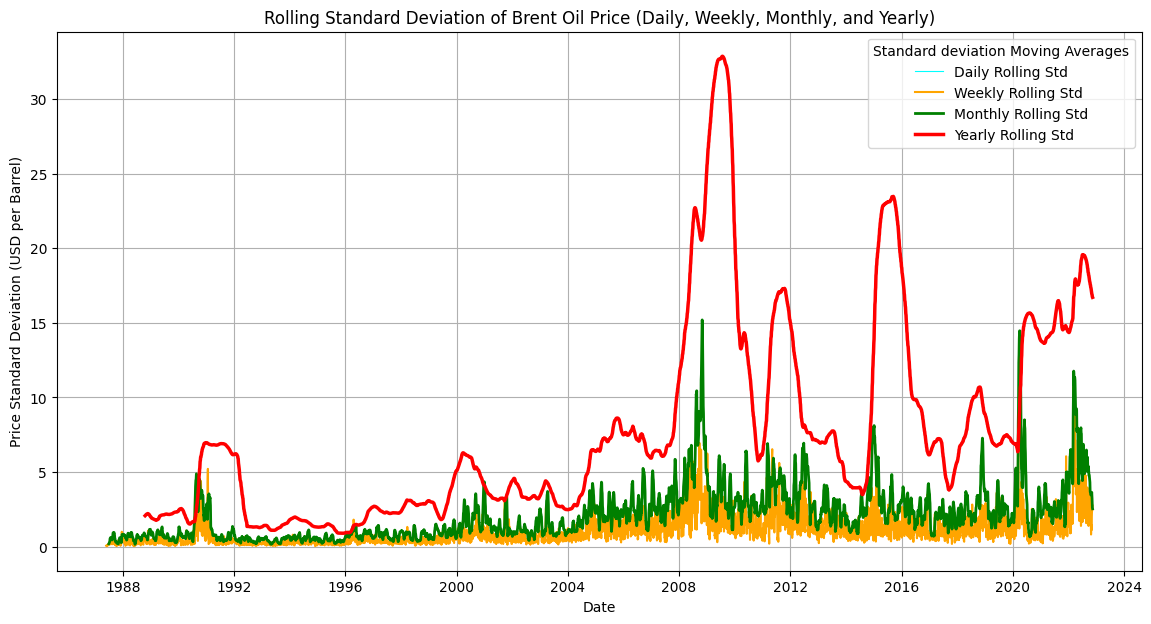

In [51]:
# Calculate rolling standard deviations with different windows (daily, weekly, monthly, yearly)
daily_rolling_std = df['Price'].rolling(window=1).std()       # Daily rolling std
weekly_rolling_std = df['Price'].rolling(window=7).std()      # Weekly rolling std
monthly_rolling_std = df['Price'].rolling(window=30).std()    # Approximate monthly rolling std
yearly_rolling_std = df['Price'].rolling(window=365).std()    # Approximate yearly rolling std

# Plot rolling standard deviations for different windows
plt.figure(figsize=(14, 7))
plt.plot(daily_rolling_std, label='Daily Rolling Std', color='cyan', linewidth=0.8)
plt.plot(weekly_rolling_std, label='Weekly Rolling Std', color='orange', linewidth=1.5)
plt.plot(monthly_rolling_std, label='Monthly Rolling Std', color='green', linewidth=2)
plt.plot(yearly_rolling_std, label='Yearly Rolling Std', color='red', linewidth=2.5)

plt.title('Rolling Standard Deviation of Brent Oil Price (Daily, Weekly, Monthly, and Yearly)')
plt.xlabel('Date')
plt.ylabel('Price Standard Deviation (USD per Barrel)')
plt.legend(title='Standard deviation Moving Averages')
plt.grid()
plt.show()

#### Brent Oil Price Histogram Distrbution

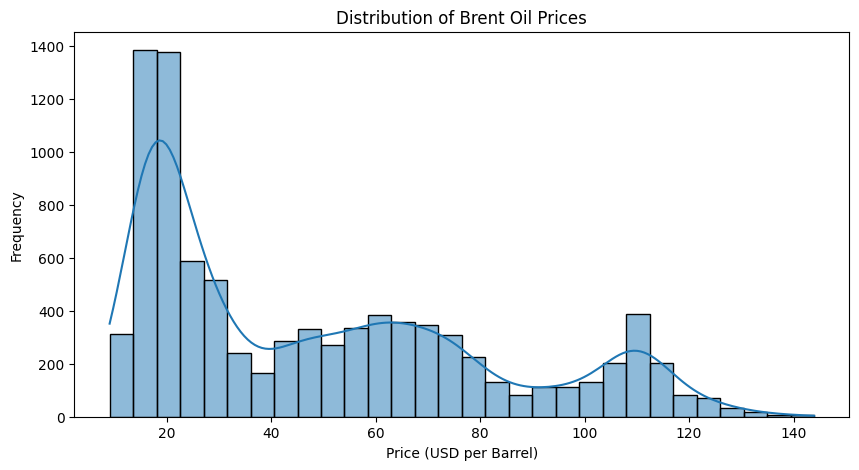

In [52]:
# Histogram of Prices
plt.figure(figsize=(10, 5))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Distribution of Brent Oil Prices')
plt.xlabel('Price (USD per Barrel)')
plt.ylabel('Frequency')
plt.show()


### Seasonal Decomposition

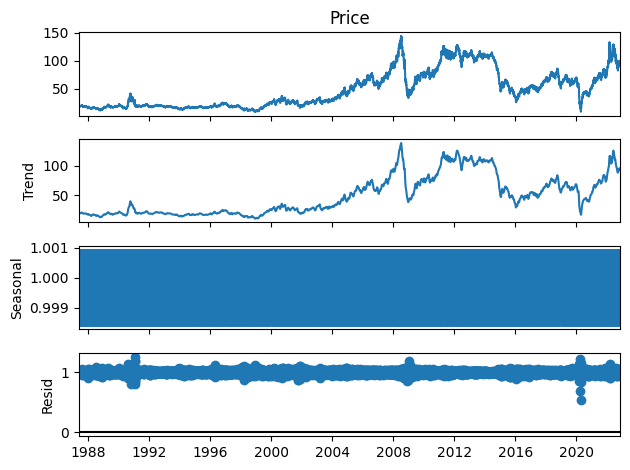

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
result = seasonal_decompose(df['Price'], model='multiplicative', period=12)

# Plot the decomposition
result.plot()
plt.show()


<Figure size 640x480 with 0 Axes>

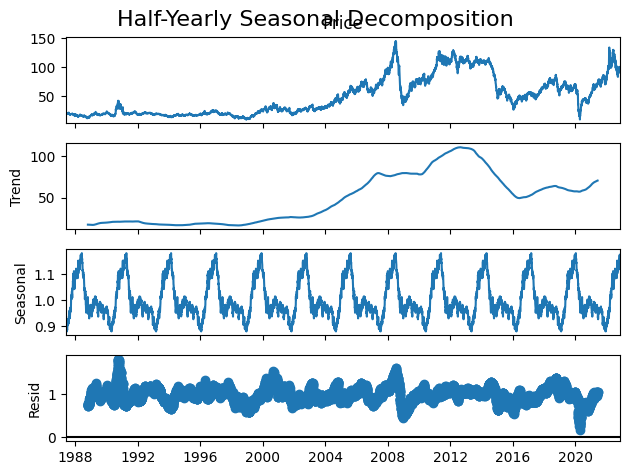

In [70]:
# Half-Yearly decomposition (assuming monthly data, 6 months in half a year)
half_yearly_result = seasonal_decompose(df['Price'], model='multiplicative', period=730)
plt.figure()
half_yearly_result.plot()
plt.suptitle("Half-Yearly Seasonal Decomposition", fontsize=16)
plt.show()

<Figure size 640x480 with 0 Axes>

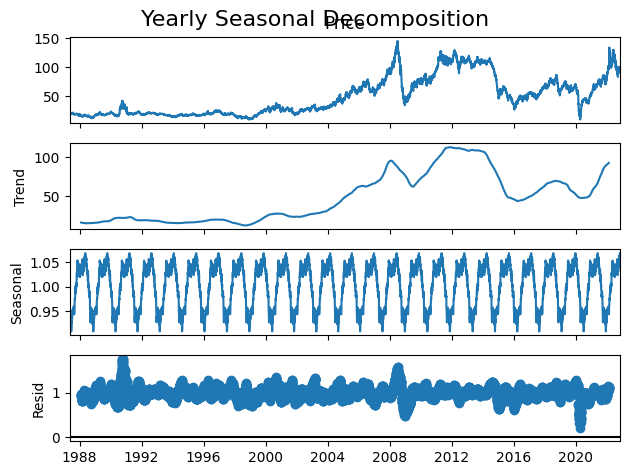

In [56]:
# Yearly decomposition (assuming daily data and approx. 365 days in a year)
yearly_result = seasonal_decompose(df['Price'], model='multiplicative', period=365)
plt.figure()
yearly_result.plot()
plt.suptitle("Yearly Seasonal Decomposition", fontsize=16)
plt.show()

##### Observation:
The time series decomposition reveals that oil prices are shaped by both a persistent long-term upward trend and a pronounced seasonal pattern. The seasonal component highlights regular fluctuations, potentially influenced by factors such as economic cycles, holiday demand, or other external conditions. The residual component indicates random variations in the data, suggesting some price movements are driven by unpredictable or short-term events not explained by the trend or seasonality.

### Autocorrelation and Partial Autocorrelation Plots

<Figure size 1200x600 with 0 Axes>

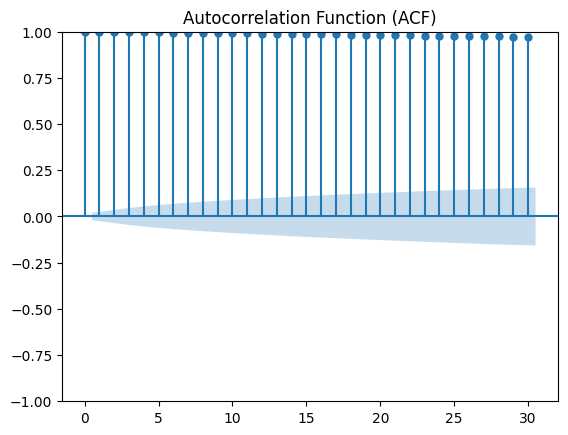

<Figure size 1200x600 with 0 Axes>

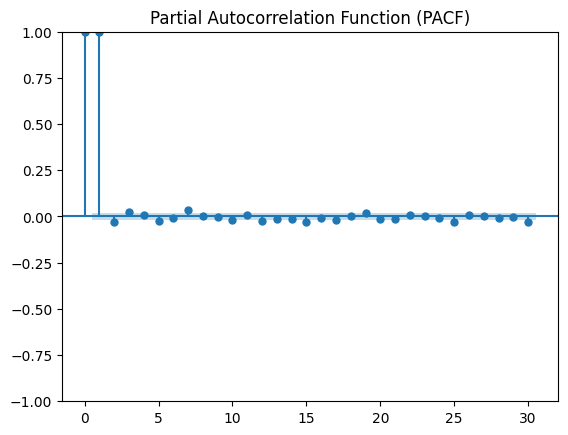

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df['Price'], lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()


Observations:

- The autocorrelation values are close to 1 across almost all lags, signaling a very strong positive correlation throughout the series. This strong relationship between past and present values suggests non-stationarity, as is typical of time series data with persistent trends.

- The autocorrelation does not decrease over time, which is another sign of non-stationarity. In stationary data, we would typically expect the autocorrelations to diminish or approach zero as lag increases.

- The blue-shaded area represents the confidence interval (often around 95%), where values within this range are considered statistically insignificant. However, nearly all lags lie outside this confidence interval, underscoring the high level of autocorrelation throughout the series.

- This autocorrelation plot suggests that the time series is likely non-stationary, meaning it exhibits persistent trends or patterns that do not stabilize over time.

<Figure size 1200x600 with 0 Axes>

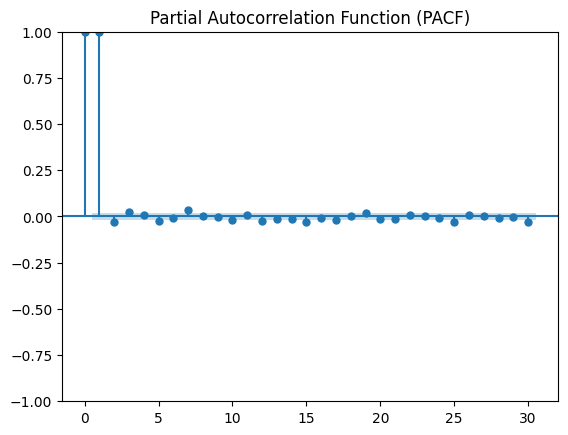

In [74]:
# Plot Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(df['Price'], lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

#### Observation:

- The first lag shows a strong positive partial autocorrelation close to 1, indicating that the current value is highly correlated with the previous value. This suggests a potential AR(1) component in an ARIMA model.

- Beyond lag 1, the partial autocorrelation quickly drops to near zero, with no significant spikes. This suggests little to no additional influence from values further back in time.

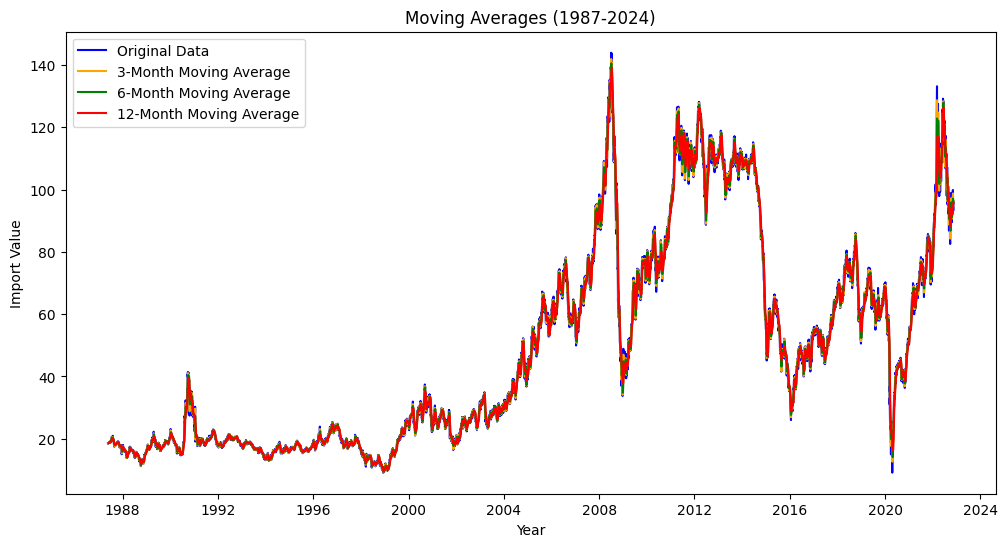

In [75]:
# Calculate the Simple Moving Average (SMA) with different window sizes

df['SMA_3'] = df['Price'].rolling(window=3).mean()  # 3-month moving average
df['SMA_6'] = df['Price'].rolling(window=6).mean()  # 6-month moving average
df['SMA_12'] = df['Price'].rolling(window=12).mean()  # 12-month moving average

# Plot the original data and the moving averages
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Original Data', color='blue')
plt.plot(df.index, df['SMA_3'], label='3-Month Moving Average', color='orange')
plt.plot(df.index, df['SMA_6'], label='6-Month Moving Average', color='green')
plt.plot(df.index, df['SMA_12'], label='12-Month Moving Average', color='red')

# Add titles and labels
plt.title('Moving Averages (1987-2024)')
plt.xlabel('Year')
plt.ylabel('Import Value')
plt.legend()
plt.grid(False)
plt.show()

#### Observation: 
we observed that the moving averages of import values from 1987 to 2024, with the original data showing notable peaks in 2008 and 2022. The 3-month, 6-month, and 12-month moving averages progressively smooth out the fluctuations, revealing short-term, medium-term, and long-term trends respectively. The 12-month moving average highlights significant trends and cycles, offering a clear view of underlying import patterns over the years.

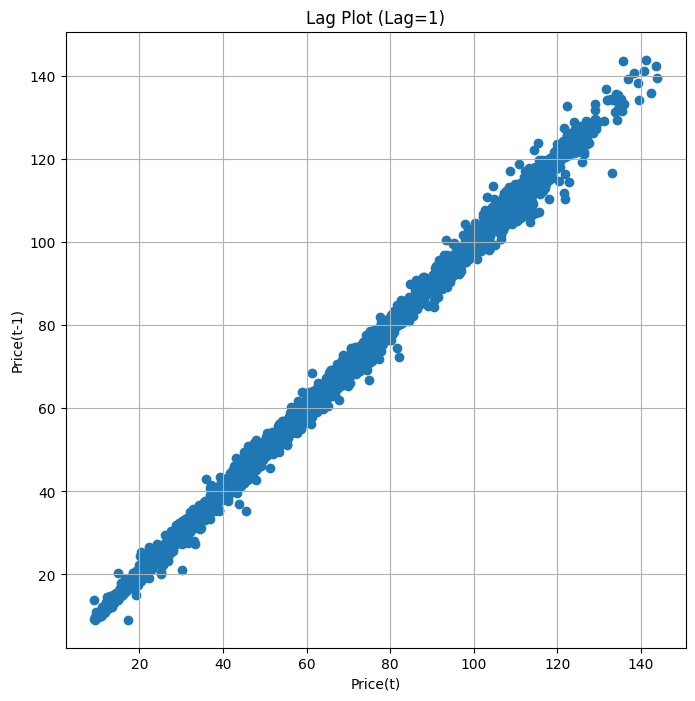

In [59]:
from pandas.plotting import lag_plot

# Plot lag plot
plt.figure(figsize=(8, 8))
lag_plot(df['Price'], lag=1)
plt.title('Lag Plot (Lag=1)')
plt.xlabel('Price(t)')
plt.ylabel('Price(t-1)')
plt.grid()
plt.show()
